In [1]:
import pandas as pd
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
import spacy
import nltk
import re
import string 
from tqdm import tqdm # Import tqdm
from text_cleaning import clean_texts_for_tfidf_batch

# Creating the db 

two separates db for senate and congress

In [4]:
CLIP_TRESHOLD = 40
clipping_stats_list = []

# Loop through congress files
for i in range(75, 112):
    
    "------ Loading files -------"
    
    year_str = f"{i:03}"
    base_dir_load = Path("../data/raw")

    speeches_file = base_dir_load / f"speeches/speeches_{year_str}.txt"
    map_file = base_dir_load / f"speaker_map/{year_str}_SpeakerMap.txt"
    metadata_file = base_dir_load /f"metadata/descr_{year_str}.txt"
    
    print("Processing:", speeches_file, map_file, metadata_file)
    df_speeches = pd.read_csv(speeches_file, sep="|", encoding="latin1", dtype={"speech_id": str}, on_bad_lines="skip", engine="python")
    df_map = pd.read_csv(map_file, encoding='windows-1252', delimiter="|")
    df_metadata = pd.read_csv(metadata_file, encoding='windows-1252', delimiter="|")

    # converts type
    df_speeches["speech_id"] = pd.to_numeric(df_speeches["speech_id"], errors="coerce").astype("Int64")
    df_map.chamber = pd.Categorical(df_map.chamber)
    df_map.party = pd.Categorical(df_map.party)
    
    "------ Dropping column -------"
    
    # Clean speaker map
    df_map = df_map.drop(["district", "nonvoting", "state", "gender"], axis=1)
    #drop also lastname firstname and char_count
    # Clean metadata
    df_metadata = df_metadata[['speech_id', 'date', 'char_count', 'word_count']]

    "------ Merging -------"
    
    df_merge1 = pd.merge(df_speeches, df_map, on="speech_id", how="outer")
    df_merged = pd.merge(df_merge1, df_metadata, on="speech_id", how="outer")
    
    #checking speaker_id when is na
    """ rows_with_speakerid_na = df_merged[df_merged['speakerid'].isna()]
    rows_with_party_na = df_merged[df_merged['party'].isna()]
    print(rows_with_speakerid_na.head())
    print(rows_with_speakerid_na.shape) """

    df_merged = df_merged.dropna(subset=["speakerid"])
    df_merged['speakerid'] = df_merged['speakerid'].astype(int)
    df_merged = df_merged[df_merged['party'].isin(['D', 'R'])]
    df_merged['party'] = df_merged['party'].cat.remove_unused_categories()
    
    #clipping speeches
    count_after_basic_cleaning = len(df_merged)
    
    # --- Check and remove NA in 'speech' column ---
    count_before_speech_na_drop = len(df_merged)
    df_merged = df_merged.dropna(subset=['speech'])
    count_after_speech_na_drop = len(df_merged)
    speech_na_removed = count_before_speech_na_drop - count_after_speech_na_drop
    
    # --- Check and remove duplicate 'speech' entries ---
    count_before_duplicate_drop = len(df_merged)
    df_merged = df_merged.drop_duplicates(subset=['speech'])
    count_after_duplicate_drop = len(df_merged)
    duplicates_removed = count_before_duplicate_drop - count_after_duplicate_drop

    # --- Clipping speeches based on word_count ---
    count_before_clip = len(df_merged)
    df_merged = df_merged[df_merged['word_count'] > CLIP_TRESHOLD]
    count_after_clip = len(df_merged)
    clipped_removed = count_before_clip - count_after_clip
    
    # Update the dictionary keys to reflect the new steps
    clipping_stats_list.append({
        'Congress': i,
        'Start Count (After Basic Clean)': count_after_basic_cleaning,
        'Removed (Speech NA)': speech_na_removed,
        'Removed (Duplicates)': duplicates_removed,
        'Removed (Clipped)': clipped_removed,
        'Final Count (After Clipping)': count_after_clip
    })
    
    #rename date to year
    df_merged['date'] = df_merged['date'].astype(str).str[:4].astype(int)
    df_merged.rename(columns={'date': 'year'}, inplace=True)
    
    # Save chamber-specific dataframes
    df_senate = df_merged[df_merged['chamber'] == 'S'].copy()
    df_house = df_merged[df_merged['chamber'] == 'H'].copy()
    
    #print(df_house.head())

    "------ Saving to csv -------"
    # Define relative base directory
    base_dir_merged = Path("../data/merged")
    base_dir_senate = Path("../data/merged/senate_db")
    base_dir_house = Path("../data/merged/house_db")

    # Construct full file paths
    filepath_senate = base_dir_senate / f"senate_merged_{year_str}.csv"
    filepath_house = base_dir_house / f"house_merged_{year_str}.csv"

    # Create the folder if it doesn't exist
    base_dir_senate.mkdir(parents=True, exist_ok=True)
    base_dir_house.mkdir(parents=True, exist_ok=True)

    # Save to CSV
    df_senate.to_csv(filepath_senate, index=False)
    df_house.to_csv(filepath_house, index=False)
    with open('clipping_stats.json', 'w') as f:
        json.dump(clipping_stats_list, f, indent=4)


Processing: ..\data\raw\speeches\speeches_075.txt ..\data\raw\speaker_map\075_SpeakerMap.txt ..\data\raw\metadata\descr_075.txt
Processing: ..\data\raw\speeches\speeches_076.txt ..\data\raw\speaker_map\076_SpeakerMap.txt ..\data\raw\metadata\descr_076.txt
Processing: ..\data\raw\speeches\speeches_077.txt ..\data\raw\speaker_map\077_SpeakerMap.txt ..\data\raw\metadata\descr_077.txt
Processing: ..\data\raw\speeches\speeches_078.txt ..\data\raw\speaker_map\078_SpeakerMap.txt ..\data\raw\metadata\descr_078.txt
Processing: ..\data\raw\speeches\speeches_079.txt ..\data\raw\speaker_map\079_SpeakerMap.txt ..\data\raw\metadata\descr_079.txt
Processing: ..\data\raw\speeches\speeches_080.txt ..\data\raw\speaker_map\080_SpeakerMap.txt ..\data\raw\metadata\descr_080.txt
Processing: ..\data\raw\speeches\speeches_081.txt ..\data\raw\speaker_map\081_SpeakerMap.txt ..\data\raw\metadata\descr_081.txt
Processing: ..\data\raw\speeches\speeches_082.txt ..\data\raw\speaker_map\082_SpeakerMap.txt ..\data\raw

## Cleaning text

In [ ]:
# Loop through Congress numbers with a progress bar
for i in tqdm(range(76, 112), desc="Processing Congresses"):
    print(f"\n--Processing Congress {i} --") # Added newline for better readability with tqdm
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"

    cleaned_dir = Path("../data/processed")
    cleaned_dir.mkdir(parents=True, exist_ok=True)

    if not house_file.exists():
        print(f"File not found, skipping: {house_file}")
        continue

    try:
        df = pd.read_csv(house_file)
    except Exception as e:
        print(f"Error reading {house_file}: {e}. Skipping.")
        continue

    if "speech" in df.columns:
        print(f"Cleaning speeches for Congress {year_str}...")
        speeches_to_clean = df["speech"].fillna("").astype(str).tolist()

        if not speeches_to_clean:
            print(f"No speeches to clean in Congress {year_str} after filtering NaNs. Skipping cleaning.")
            continue

        # Use the batch cleaning function
        # If clean_texts_for_tfidf_batch has its own tqdm, it will be a nested bar
        cleaned_speeches_list = clean_texts_for_tfidf_batch(speeches_to_clean)
        df["cleaned_speech"] = cleaned_speeches_list

        output_cleaned = cleaned_dir / f"house_cleaned_{year_str}.csv"

        # Define columns to keep *after* 'cleaned_speech' is created
        columns_to_keep = ["speech_id", 'speakerid', 'party', 'cleaned_speech']
        # Ensure only existing columns are selected
        columns_to_keep = [col for col in columns_to_keep if col in df.columns]

        if 'cleaned_speech' in df.columns and 'cleaned_speech' in columns_to_keep:
            df_to_save = df[columns_to_keep].copy()
            df_to_save.rename(columns={'cleaned_speech': 'speech'}, inplace=True) # Rename for consistency

            try:
                df_to_save.to_csv(output_cleaned, index=False)
                print(f"Saved cleaned data for Congress {year_str} to {output_cleaned}")
            except Exception as e:
                print(f"Error saving cleaned data for Congress {year_str} to {output_cleaned}: {e}")
        elif 'cleaned_speech' not in df.columns:
            print(f"Column 'cleaned_speech' not generated for {year_str}. Skipping save.")
        else:
            print(f"Column 'cleaned_speech' was generated but not selected in columns_to_keep for {year_str}. Skipping save.")
    else:
        print(f"'speech' column not found in {house_file}. Skipping cleaning.")

print("\nAll Congresses processed.")

--Cleaning Congress 76 
Cleaning speeches for Congress 076...
Saved cleaned data for Congress 076 to ..\data\processed\house_cleaned_076.csv
--Cleaning Congress 77 
Cleaning speeches for Congress 077...
Saved cleaned data for Congress 077 to ..\data\processed\house_cleaned_077.csv
--Cleaning Congress 78 
Cleaning speeches for Congress 078...
Saved cleaned data for Congress 078 to ..\data\processed\house_cleaned_078.csv
--Cleaning Congress 79 
Cleaning speeches for Congress 079...
Saved cleaned data for Congress 079 to ..\data\processed\house_cleaned_079.csv
--Cleaning Congress 80 
Cleaning speeches for Congress 080...
Saved cleaned data for Congress 080 to ..\data\processed\house_cleaned_080.csv
--Cleaning Congress 81 
Cleaning speeches for Congress 081...
Saved cleaned data for Congress 081 to ..\data\processed\house_cleaned_081.csv
--Cleaning Congress 82 
Cleaning speeches for Congress 082...
Saved cleaned data for Congress 082 to ..\data\processed\house_cleaned_082.csv
--Cleaning Co

KeyboardInterrupt: 

Working on clip

In [ ]:
year_str = f"{79:03}"
base_dir = Path("../data/merged")
house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
df = pd.read_csv(house_file)

word_count_threshold = 40 # Example: speeches with fewer than 100 words
number_of_samples = 50     # Example: how many speeches to sample
# --- Filter the DataFrame based on the word count threshold ---
df_short_speeches = df[df['word_count'] < word_count_threshold]
df_short_speeches = df_short_speeches[['speech_id', 'speech','word_count']]

sampled_speeches = df_short_speeches.sample(n=number_of_samples) # Using a random_state for reproducibility

# --- Adjust pandas display options to show full column width ---
# Store current options to restore them later (good practice)
original_max_colwidth = pd.get_option('display.max_colwidth')
original_max_columns = pd.get_option('display.max_columns') # Also good to show all columns

# Set new options
# Set max_colwidth to None to show *all* text in the column.
# Be cautious: if speeches are extremely long, this can produce massive output.
# Alternatively, set it to a large integer (e.g., 5000) to see a significant portion.
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) # Ensure all columns are shown, not just first/last

# --- Now print the sampled DataFrame (it will use the new display options) ---
print("\n--- Sampled Speeches with Full Speech Text Displayed ---")
print(sampled_speeches)

# --- IMPORTANT: Restore original pandas display options ---
pd.set_option('display.max_colwidth', original_max_colwidth)
pd.set_option('display.max_columns', original_max_columns)

print("\n--- Pandas display options restored ---")




--- Clipping Statistics Summary ---
    Congress  Start Count (After Basic Clean)  Removed (Speech NA)  \
0         75                           200344                  573   
1         76                           241592                 1016   
2         77                           203758                  813   
3         78                           207535                 1854   
4         79                           209920                 1171   
5         80                           167446                  793   
6         81                           278915                  629   
7         82                           214505                  483   
8         83                           210605                  625   
9         84                           167026                  468   
10        85                           218268                  271   
11        86                           224178                  116   
12        87                           225267        

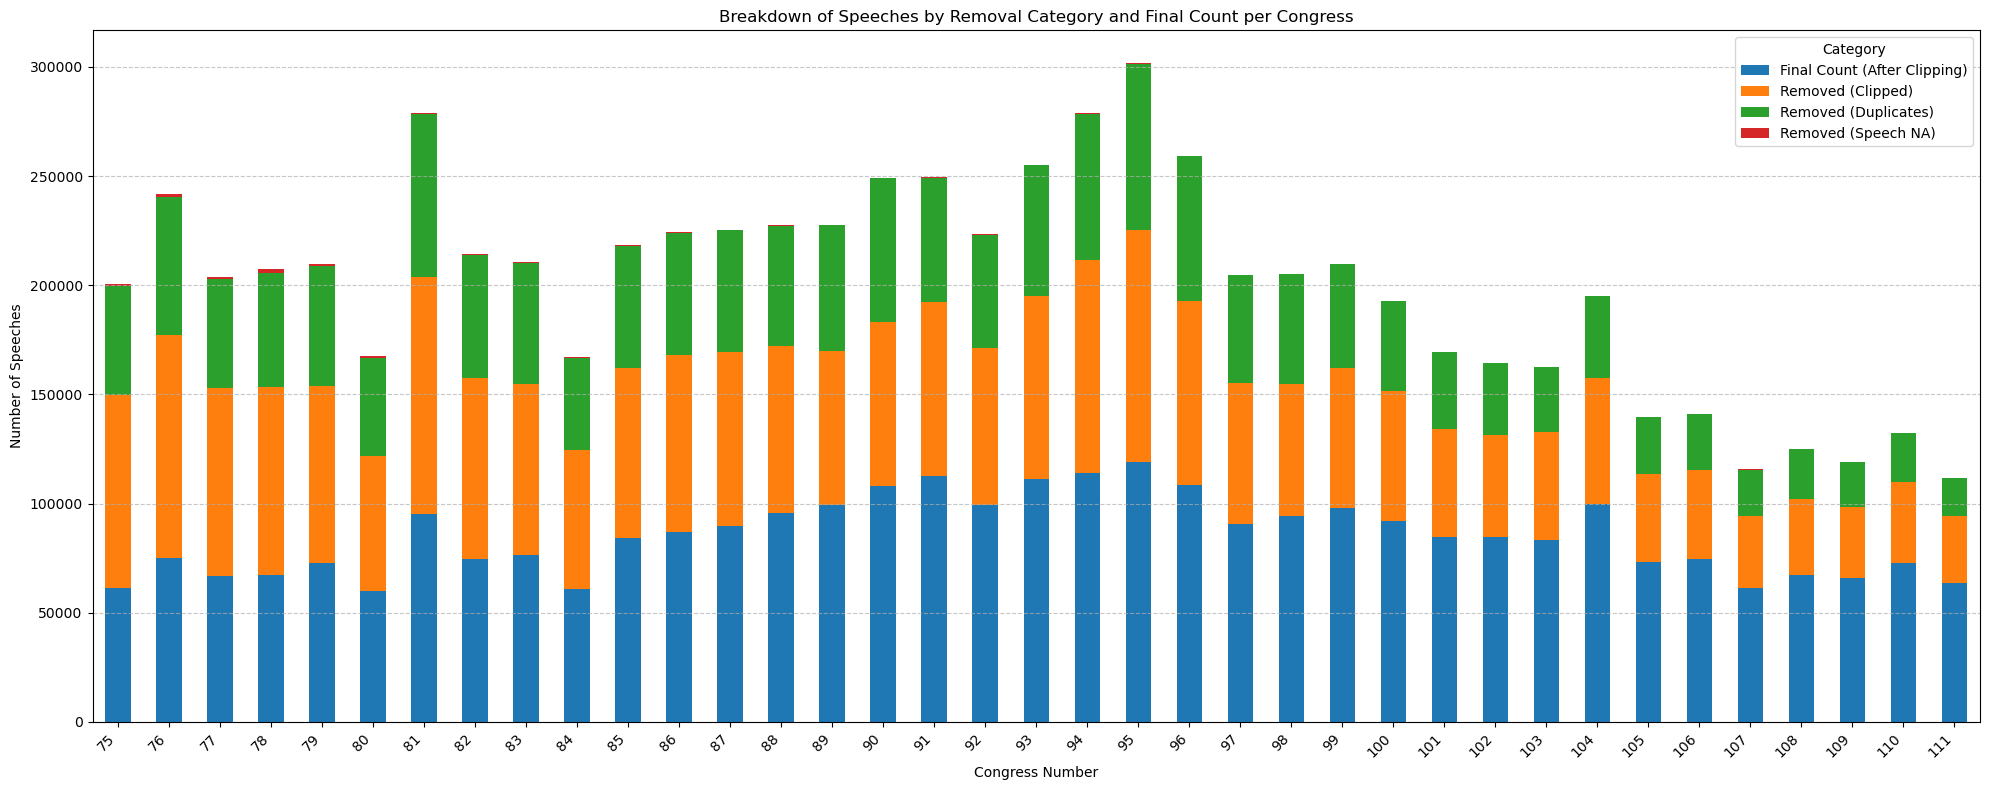

Generating Line Plot (Percentages)...


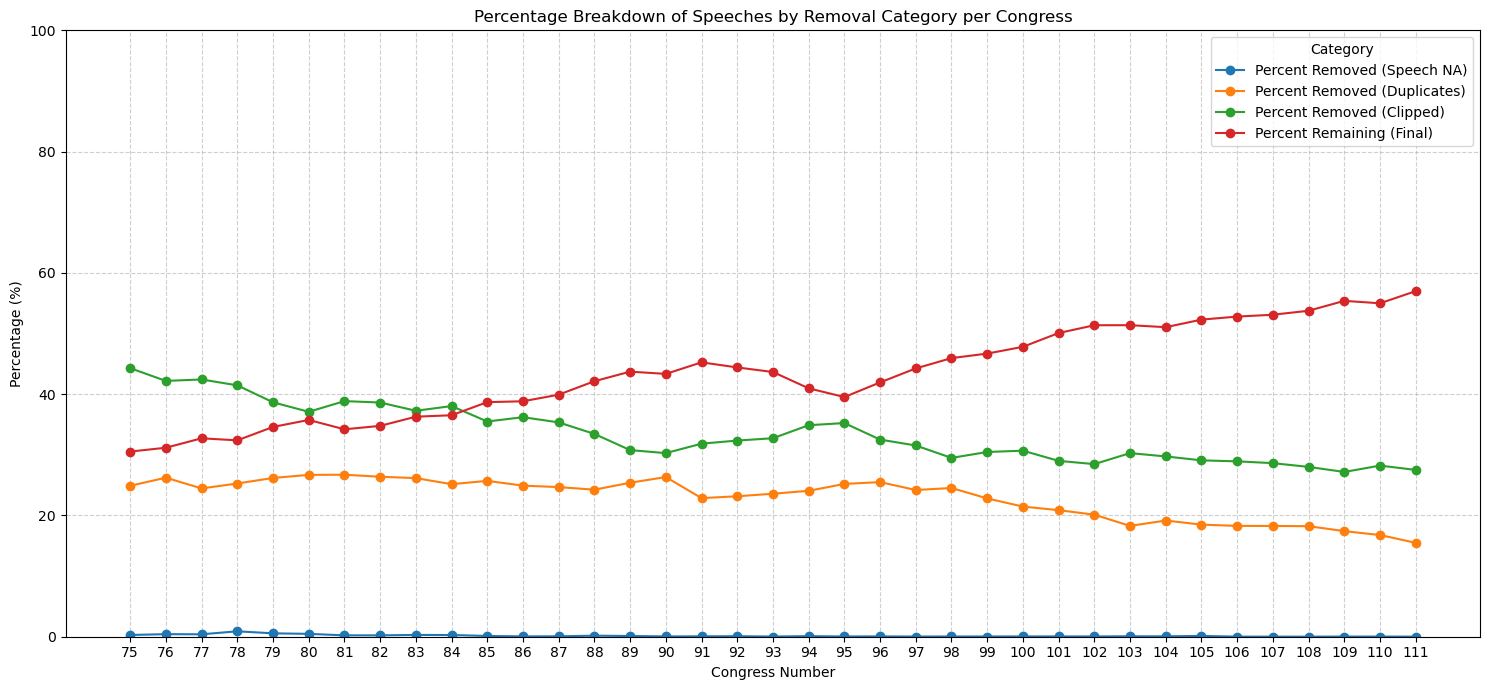

In [5]:
#loading stats
with open ("clipping_stats.json", "r") as f:
    clipping_stats_list = json.load(f)
    
clipping_stats_df = pd.DataFrame(clipping_stats_list)

# Optional: Sort the DataFrame by Congress number for a cleaner plot (Same as before)
clipping_stats_df = clipping_stats_df.sort_values('Congress').reset_index(drop=True)

# Print the final statistics table (optional)
print("\n--- Clipping Statistics Summary ---")
print(clipping_stats_df)

# 2. Calculate Percentage Statistics (UPDATED)
# Calculate percentages relative to the 'Start Count (After Basic Clean)'
# Handle potential division by zero by replacing 0 in the base count with NaN before division
base_count = clipping_stats_df['Start Count (After Basic Clean)'].replace(0, np.nan)

clipping_stats_df['Percent Removed (Speech NA)'] = (clipping_stats_df['Removed (Speech NA)'] / base_count) * 100
clipping_stats_df['Percent Removed (Duplicates)'] = (clipping_stats_df['Removed (Duplicates)'] / base_count) * 100
clipping_stats_df['Percent Removed (Clipped)'] = (clipping_stats_df['Removed (Clipped)'] / base_count) * 100
clipping_stats_df['Percent Remaining (Final)'] = (clipping_stats_df['Final Count (After Clipping)'] / base_count) * 100


# Replace any inf or NaN values (resulting from division by zero or NaN base_count) with 0
pct_cols_to_fill = ['Percent Removed (Speech NA)', 'Percent Removed (Duplicates)', 'Percent Removed (Clipped)', 'Percent Remaining (Final)']
clipping_stats_df[pct_cols_to_fill] = clipping_stats_df[pct_cols_to_fill].replace([np.inf, -np.inf], np.nan).fillna(0)


# --- 3. Visualize Raw Counts using a STACKED Bar Plot (UPDATED) ---
print("\nGenerating Stacked Bar Plot (Raw Counts)...")
plt.figure(figsize=(20, 8)) # Create a new figure for the bar plot

# Set Congress as the index for plotting
clipping_stats_df_indexed_bar = clipping_stats_df.set_index('Congress')

# Select the columns you want to plot as stacked bars.
# Order matters for the stack layers. Placing 'Final Count' at the bottom is common.
columns_to_stack = [
    'Final Count (After Clipping)',
    'Removed (Clipped)',         # Clipped on top of Final
    'Removed (Duplicates)',      # Duplicates on top of Clipped
    'Removed (Speech NA)'        # Speech NA on top of Duplicates
]

ax_bar = clipping_stats_df_indexed_bar[columns_to_stack].plot(
    kind='bar',
    stacked=True, # This makes it a stacked bar plot
    ax=plt.gca() # Use the current axes created by plt.figure()
)

# Add titles and labels
plt.title('Breakdown of Speeches by Removal Category and Final Count per Congress')
plt.xlabel('Congress Number')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid

# Improve layout
plt.tight_layout()

# Show the bar plot
plt.show()


# --- 4. Visualize Percentage Statistics using a Line Plot (UPDATED) ---
print("Generating Line Plot (Percentages)...")
plt.figure(figsize=(15, 7)) # Create a new figure for the line plot

# Use the 'Congress' column directly for the x-axis
# Select the new percentage columns to plot
percentage_columns_to_plot = [
    'Percent Removed (Speech NA)',
    'Percent Removed (Duplicates)',
    'Percent Removed (Clipped)',
    'Percent Remaining (Final)'
]

ax_line = clipping_stats_df.plot(
    x='Congress',
    y=percentage_columns_to_plot,
    kind='line',
    marker='o', # Add markers
    ax=plt.gca() # Use the current axes created by plt.figure()
)

# Add titles and labels
plt.title('Percentage Breakdown of Speeches by Removal Category per Congress')
plt.xlabel('Congress Number')
plt.ylabel('Percentage (%)')
plt.xticks(clipping_stats_df['Congress']) # Ensure all Congress numbers are shown
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid
plt.legend(title='Category')

# Set y-axis limits from 0 to 100
plt.ylim(0, 100)

# Improve layout
plt.tight_layout()

# Show the line plot
plt.show()


# Optional: Save the statistics DataFrame to a CSV file
# stats_output_path = Path("../data/processing_stats/clipping_summary.csv")
# stats_output_path.parent.mkdir(parents=True, exist_ok=True)
# # Save the version *with* percentages now
# clipping_stats_df.to_csv(stats_output_path, index=False)
# print(f"\nClipping statistics saved to {stats_output_path}")

# --- END SNIPPET ---

# Fetching stats

### House of Representative stats

In [32]:
house_result_frames = []
house_speech_length_stats = []

for i in range(75, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
    df = pd.read_csv(house_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    house_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))     
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = house_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    house_party_year_stats['pct_speeches'] = (
        house_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    house_party_year_stats['pct_speakers'] = (
        house_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    house_party_year_stats = house_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = house_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        house_party_year_stats = house_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")
        
    house_party_year_stats['Congress number'] = i

    house_result_frames.append(house_party_year_stats.reset_index())
    
    stats = df["word_count"].describe().to_frame().T
    stats["Congress number"] = i
    house_speech_length_stats.append(stats)
    
    #print(house_party_year_stats.round(1))
    
house_speech_stats_df = pd.concat(house_speech_length_stats, ignore_index=True)
house_speech_length_df = house_speech_stats_df.round({
    'mean': 2,
    'std': 2
})

all_stats_house = pd.concat(house_result_frames, ignore_index=True)

── Processing Congress 75 ──
── Processing Congress 76 ──
removed tiny-overlap year(s): [1941]
── Processing Congress 77 ──
── Processing Congress 78 ──
── Processing Congress 79 ──
── Processing Congress 80 ──
── Processing Congress 81 ──
removed tiny-overlap year(s): [1951]
── Processing Congress 82 ──
── Processing Congress 83 ──
── Processing Congress 84 ──
── Processing Congress 85 ──
── Processing Congress 86 ──
── Processing Congress 87 ──
── Processing Congress 88 ──
── Processing Congress 89 ──
── Processing Congress 90 ──
── Processing Congress 91 ──
removed tiny-overlap year(s): [1971]
── Processing Congress 92 ──
── Processing Congress 93 ──
── Processing Congress 94 ──
── Processing Congress 95 ──
── Processing Congress 96 ──
── Processing Congress 97 ──
── Processing Congress 98 ──
── Processing Congress 99 ──
── Processing Congress 100 ──
── Processing Congress 101 ──
── Processing Congress 102 ──
── Processing Congress 103 ──
── Processing Congress 104 ──
── Processing 

In [31]:
print(house_speech_length_df)


      count    mean     std   min    25%    50%     75%      max  \
0   30891.0  230.84  392.15  41.0   57.0   95.0  233.00  10755.0   
1   37961.0  250.24  411.11  41.0   59.0  102.0  261.00  10301.0   
2   37644.0  238.74  385.50  41.0   59.0  102.0  248.00   8303.0   
3   37647.0  254.13  429.60  41.0   59.0  104.0  257.00   8406.0   
4   33622.0  266.04  442.59  41.0   62.0  112.0  277.00  12783.0   
5   25281.0  280.54  443.95  41.0   64.0  127.0  312.00  11089.0   
6   33025.0  271.27  432.95  41.0   62.0  114.0  294.00   6691.0   
7   29677.0  268.06  430.13  41.0   63.0  115.0  290.00  11478.0   
8   27546.0  288.27  454.65  41.0   64.0  122.0  322.00  15092.0   
9   26949.0  297.06  470.57  41.0   63.0  121.0  326.00   8226.0   
10  33817.0  302.24  483.30  41.0   67.0  133.0  338.00  20934.0   
11  30265.0  315.03  479.26  41.0   68.0  140.0  358.00   9927.0   
12  34845.0  320.85  481.79  41.0   71.0  146.0  367.00  12531.0   
13  36660.0  335.46  483.19  41.0   76.0  167.0 

In [33]:
print(all_stats_house)

     year       party  num_speeches  pct_speeches  num_speakers  pct_speakers  \
0    1937    Democrat         12064     66.685092           290     77.127660   
1    1937  Republican          6027     33.314908            86     22.872340   
2    1938    Democrat          8140     63.593750           281     77.410468   
3    1938  Republican          4660     36.406250            82     22.589532   
4    1939    Democrat          9711     56.413384           233     59.590793   
..    ...         ...           ...           ...           ...           ...   
143  2008  Republican          7359     42.660870           198     44.897959   
144  2009    Democrat         13152     50.730955           264     59.863946   
145  2009  Republican         12773     49.269045           177     40.136054   
146  2010    Democrat          8635     58.332770           259     58.863636   
147  2010  Republican          6168     41.667230           181     41.136364   

     mean_words  Congress n

### Senate stats

In [38]:
senate_result_frames = []
senate_speech_length_stats = []

for i in range(75, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    senate_file = base_dir / f"senate_db/senate_merged_{year_str}.csv"
    df = pd.read_csv(senate_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    senate_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))      
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = senate_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    senate_party_year_stats['pct_speeches'] = (
        senate_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    senate_party_year_stats['pct_speakers'] = (
        senate_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    senate_party_year_stats = senate_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = senate_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        senate_party_year_stats = senate_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")
        
    senate_party_year_stats['Congress number'] = i
    
    senate_result_frames.append(senate_party_year_stats.reset_index())
    stats = df["word_count"].describe().to_frame().T
    stats["Congress number"] = i
    senate_speech_length_stats.append(stats)

senate_speech_stats_df = pd.concat(senate_speech_length_stats, ignore_index=True)
senate_speech_length_df = senate_speech_stats_df.round({
    'mean': 2,
    'std': 2
})

all_stats_senate = pd.concat(senate_result_frames, ignore_index=True)
    #print(senate_party_year_stats.round(1))

── Processing Congress 75 ──
── Processing Congress 76 ──
removed tiny-overlap year(s): [1941]
── Processing Congress 77 ──
── Processing Congress 78 ──
── Processing Congress 79 ──
── Processing Congress 80 ──
── Processing Congress 81 ──
removed tiny-overlap year(s): [1951]
── Processing Congress 82 ──
── Processing Congress 83 ──
── Processing Congress 84 ──
── Processing Congress 85 ──
── Processing Congress 86 ──
── Processing Congress 87 ──
── Processing Congress 88 ──
── Processing Congress 89 ──
── Processing Congress 90 ──
── Processing Congress 91 ──
removed tiny-overlap year(s): [1971]
── Processing Congress 92 ──
── Processing Congress 93 ──
── Processing Congress 94 ──
── Processing Congress 95 ──
── Processing Congress 96 ──
── Processing Congress 97 ──
── Processing Congress 98 ──
── Processing Congress 99 ──
── Processing Congress 100 ──
── Processing Congress 101 ──
── Processing Congress 102 ──
── Processing Congress 103 ──
── Processing Congress 104 ──
── Processing 

In [ ]:
print()

# Graph stats

## House

1

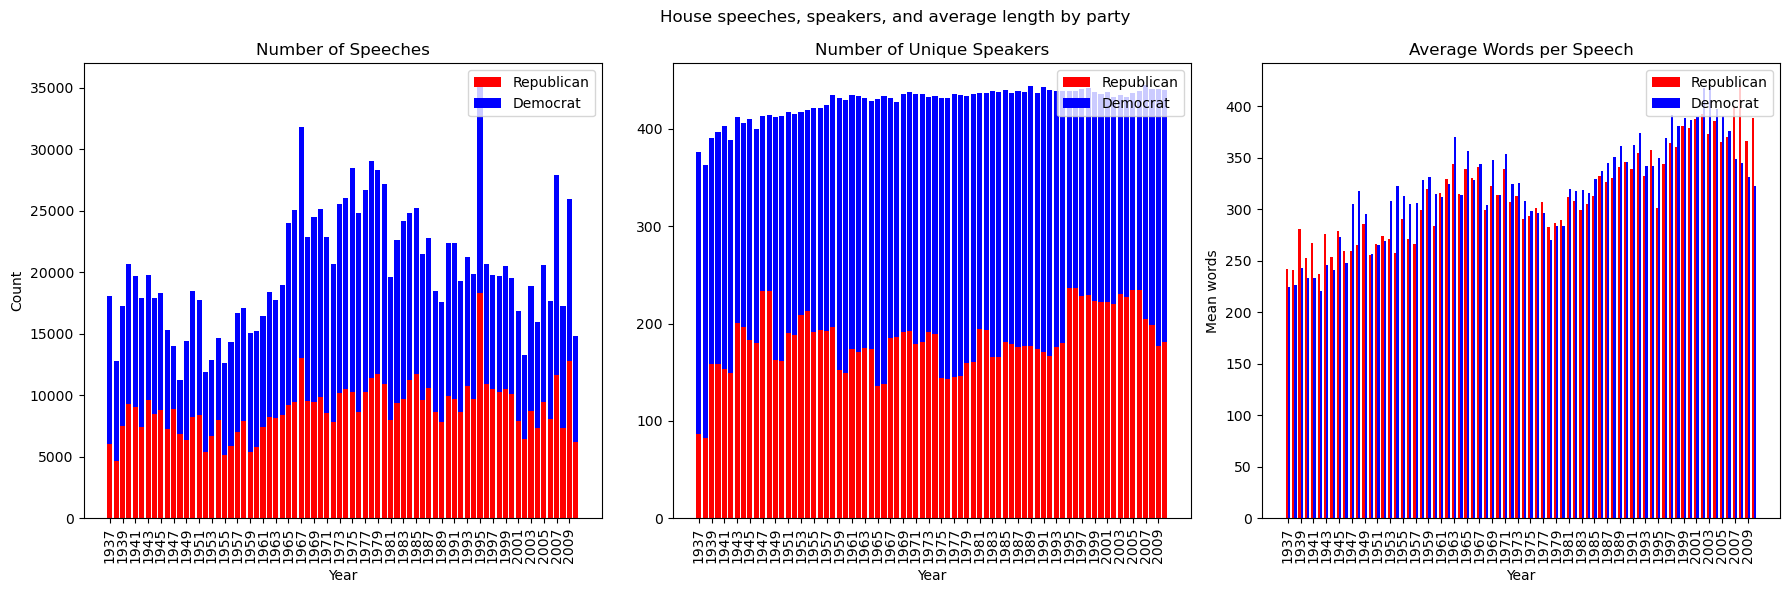

In [19]:
# ---------- collect the tables built in Cell 1 ----------
all_stats = pd.concat(house_result_frames, ignore_index=True)


agg = (
    all_stats
    .groupby(['year', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
        num_speakers=('num_speakers', 'sum'),
        mean_words  =('mean_words',  'mean'))
)

# wide tables
speech_pct   = all_stats.pivot(index='year', columns='party', values='pct_speeches').fillna(0)
speaker_pct  = all_stats.pivot(index='year', columns='party', values='pct_speakers').fillna(0)
speech_vals  = agg.pivot(index='year', columns='party', values='num_speeches').fillna(0)
speaker_vals = agg.pivot(index='year', columns='party', values='num_speakers').fillna(0)
mean_words   = agg.pivot(index='year', columns='party', values='mean_words').fillna(0)


# make sure both parties are present
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

years = speech_vals.index.astype(str)
x     = np.arange(len(years))          # numeric x‑positions

# assume speech_vals, speaker_vals, mean_words are already built
years = speech_vals.index.astype(str)
x     = np.arange(len(years))

rs, ds = speech_vals['Republican'],  speech_vals['Democrat']
ru, du = speaker_vals['Republican'], speaker_vals['Democrat']
rw, dw = mean_words['Republican'],   mean_words['Democrat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# A ‒ speeches
axes[0].bar(x, rs, color='red',  label='Republican')
axes[0].bar(x, ds, bottom=rs, color='blue', label='Democrat')
axes[0].set_title('Number of Speeches')
axes[0].set_ylabel('Count')

# B ‒ speakers
axes[1].bar(x, ru, color='red',  label='Republican')
axes[1].bar(x, du, bottom=ru, color='blue', label='Democrat')
axes[1].set_title('Number of Unique Speakers')

# C ‒ mean words (side‑by‑side)
bar_w = 0.35
axes[2].bar(x - bar_w/2, rw, width=bar_w, color='red',  label='Republican')
axes[2].bar(x + bar_w/2, dw, width=bar_w, color='blue', label='Democrat')
axes[2].set_title('Average Words per Speech')
axes[2].set_ylabel('Mean words')

# -------------- show only every 2nd year -----------------------------
tick_pos   = x[::2]      # 0, 2, 4, …
tick_labels = years[::2]

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Year')
    ax.legend(loc='upper right')

fig.suptitle('House speeches, speakers, and average length by party')
plt.tight_layout()
plt.show()


2

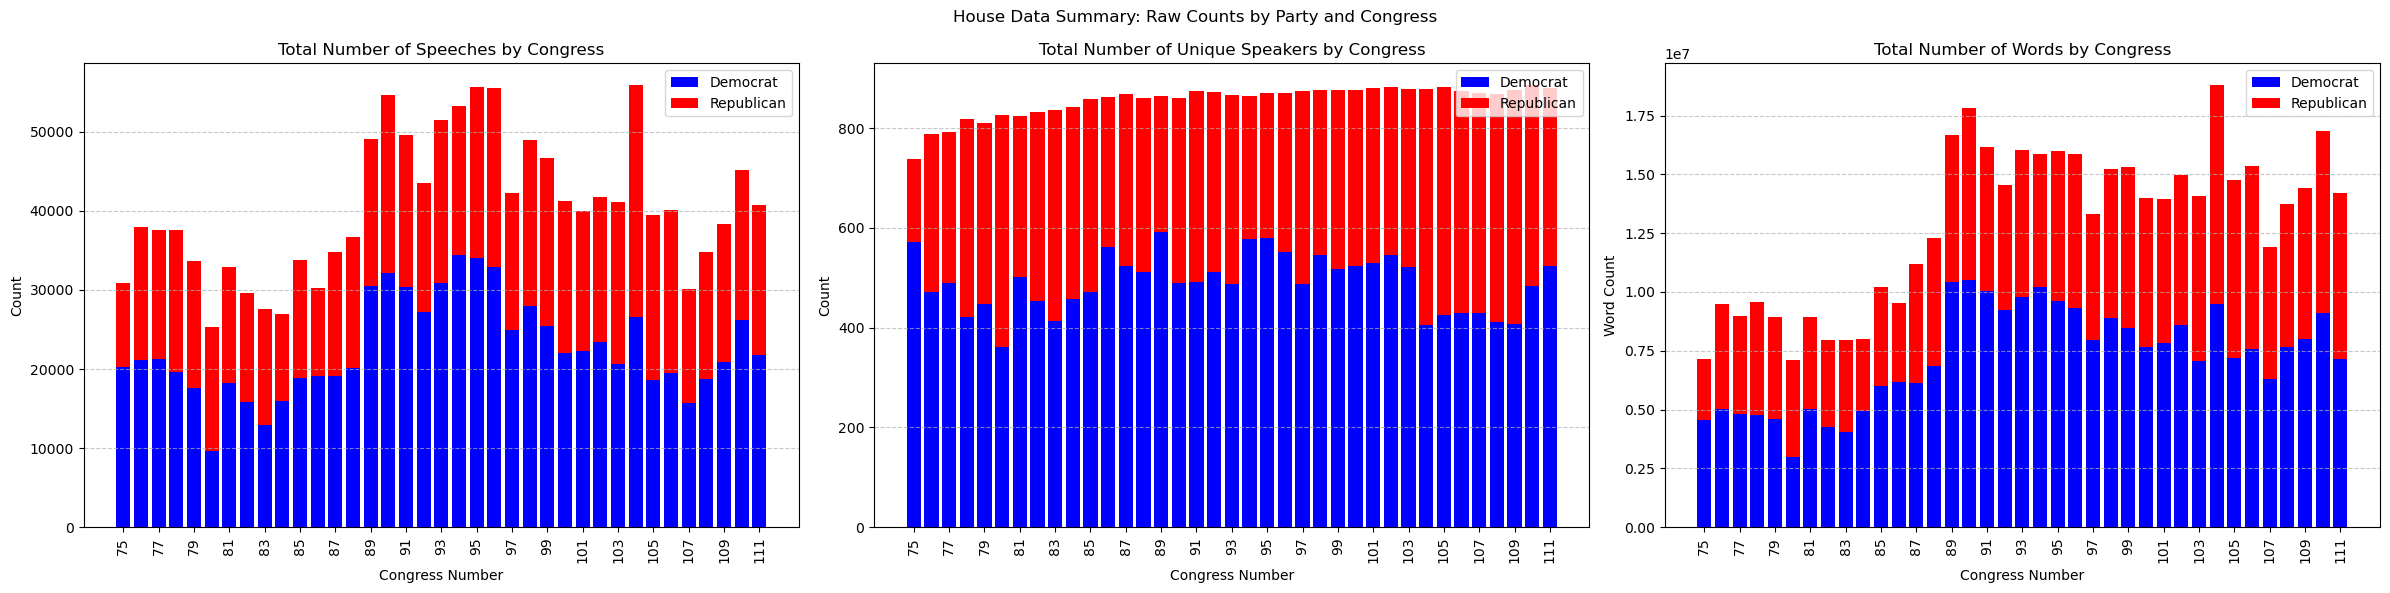

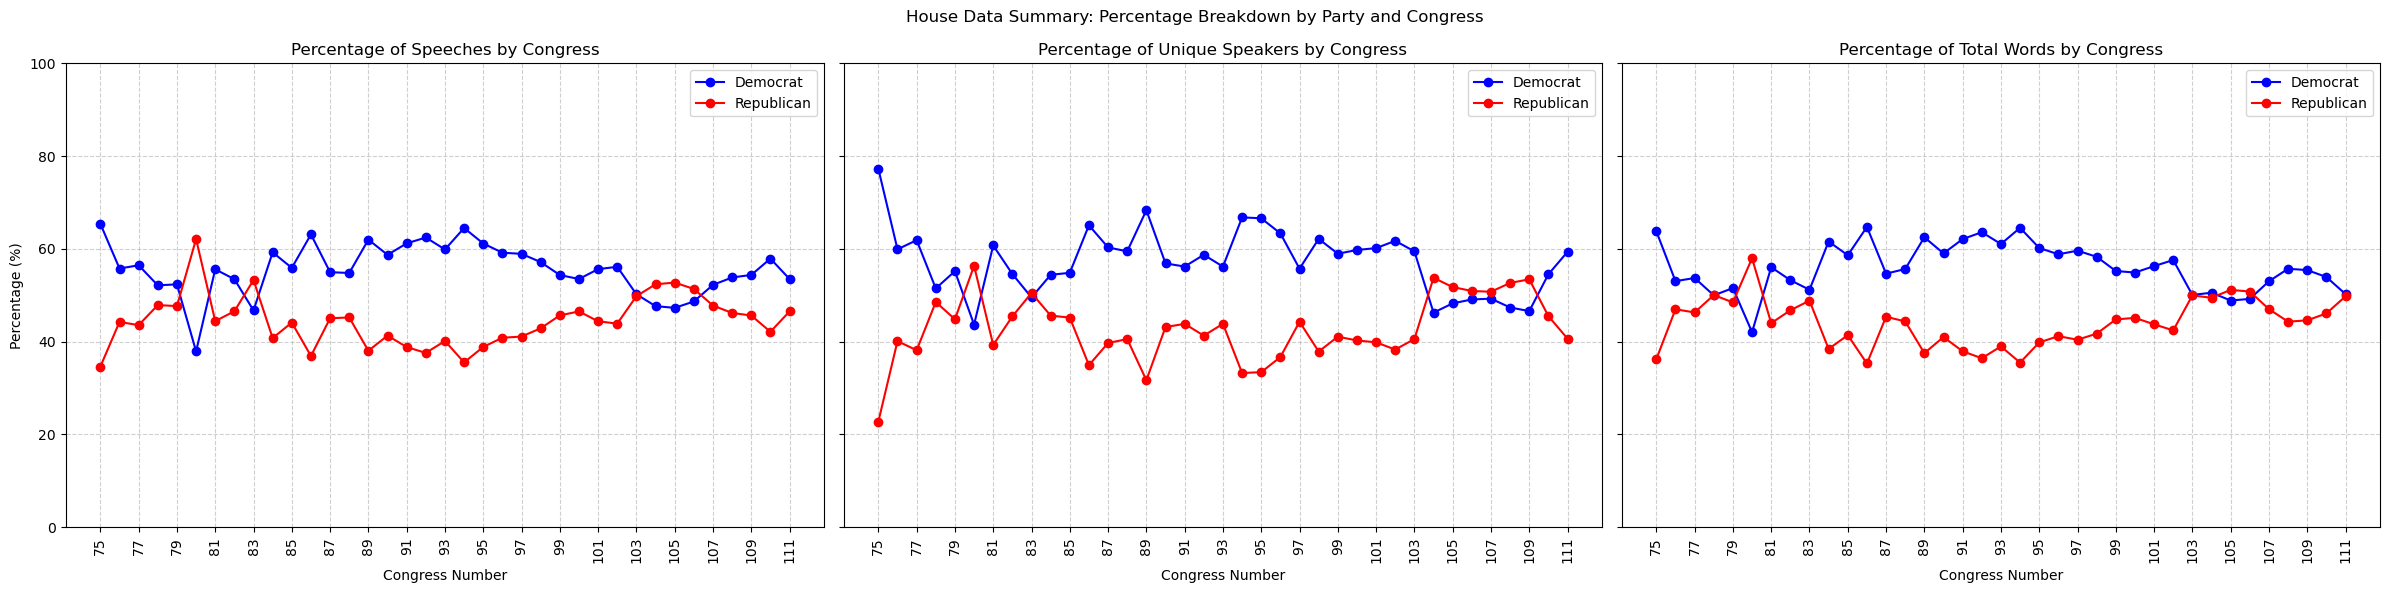

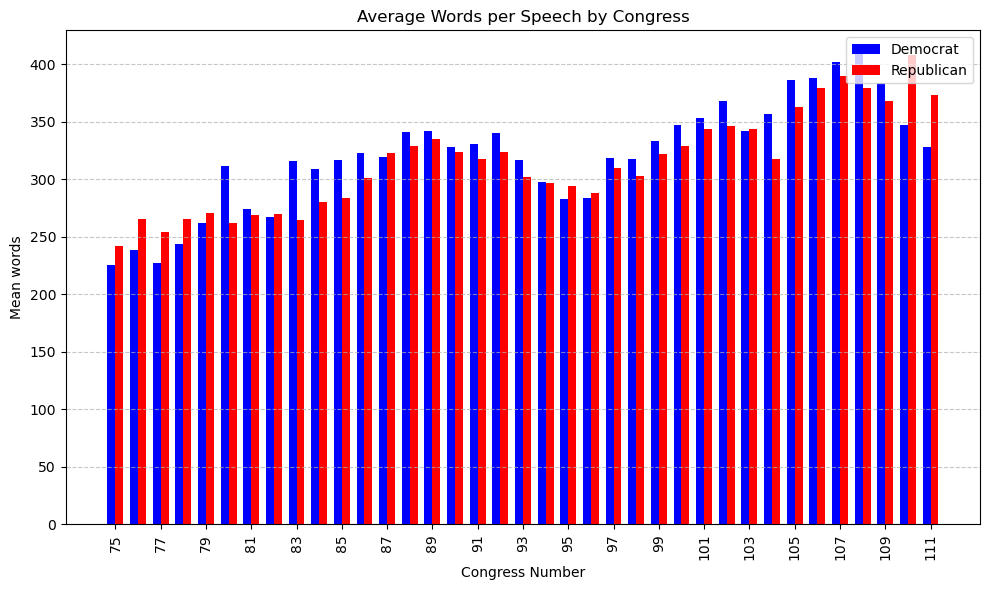

In [ ]:

# Aggregate by 'Congress number' and 'party' first
# This ensures unique combinations of 'Congress number' and 'party'
agg = (
    all_stats_house
    .groupby(['Congress number', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
         num_speakers=('num_speakers', 'sum'),
         # For mean_words, taking the mean of the yearly means might not be perfectly accurate
         # if the number of speeches varies greatly by year within a congress.
         # A more accurate approach would be to calculate total words per party per congress
         # and then divide by total speeches per party per congress.
         # Let's calculate total words first and then derive mean words per congress.
         total_words_sum=('num_speeches', lambda x: (x * all_stats_house.loc[x.index, 'mean_words']).sum())
         # The lambda function above calculates the sum of (speeches * mean_words) for each group
    )
)

# Now calculate the mean_words at the Congress level from the aggregated total_words_sum
agg['mean_words'] = agg['total_words_sum'] / agg['num_speeches']

# Drop the intermediate total_words_sum column
agg = agg.drop(columns=['total_words_sum'])


# Create wide tables using the aggregated 'agg' DataFrame
speech_vals    = agg.pivot(index='Congress number', columns='party', values='num_speeches').fillna(0)
speaker_vals   = agg.pivot(index='Congress number', columns='party', values='num_speakers').fillna(0)
mean_words     = agg.pivot(index='Congress number', columns='party', values='mean_words').fillna(0)

# Calculate total words at the Congress level from the aggregated data
total_words_vals = (speech_vals * mean_words).fillna(0)


# Calculate percentages based on the Congress-level totals
congress_total_speeches = speech_vals.sum(axis=1)
congress_total_speakers = speaker_vals.sum(axis=1)
congress_total_words    = total_words_vals.sum(axis=1)

# Avoid division by zero
congress_total_speeches = congress_total_speeches.replace(0, np.nan)
congress_total_speakers = congress_total_speakers.replace(0, np.nan)
congress_total_words    = congress_total_words.replace(0, np.nan)


speech_pct = speech_vals.divide(congress_total_speeches, axis=0) * 100
speaker_pct = speaker_vals.divide(congress_total_speakers, axis=0) * 100
total_words_pct = total_words_vals.divide(congress_total_words, axis=0) * 100

# Fill NaNs created by division by zero
speech_pct = speech_pct.fillna(0)
speaker_pct = speaker_pct.fillna(0)
total_words_pct = total_words_pct.fillna(0)


# Ensure both parties are present in all tables after pivoting and calculations
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, total_words_vals, total_words_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

# Use 'Congress number' for x-axis labels and positions
congress_numbers = speech_vals.index.astype(str)
x                = np.arange(len(congress_numbers)) # numeric x‑positions

# Sort columns to ensure consistent order for stacking (e.g., Democrat then Republican)
party_order = ['Democrat', 'Republican']
speech_vals = speech_vals[party_order]
speaker_vals = speaker_vals[party_order]
total_words_vals = total_words_vals[party_order]
speech_pct = speech_pct[party_order]
speaker_pct = speaker_pct[party_order]
total_words_pct = total_words_pct[party_order]
mean_words = mean_words[party_order]


# --- Plotting Raw Counts (3 plots) ---
fig_raw, axes_raw = plt.subplots(1, 3, figsize=(24, 6), sharex=True) # Shared x-axis

# Plot Raw Speeches (Stacked Bar)
axes_raw[0].bar(x, speech_vals['Democrat'], color='blue', label='Democrat')
axes_raw[0].bar(x, speech_vals['Republican'], bottom=speech_vals['Democrat'], color='red', label='Republican')
axes_raw[0].set_title('Total Number of Speeches by Congress')
axes_raw[0].set_ylabel('Count')
axes_raw[0].legend(loc='upper right')
axes_raw[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Raw Unique Speakers (Stacked Bar)
axes_raw[1].bar(x, speaker_vals['Democrat'], color='blue', label='Democrat')
axes_raw[1].bar(x, speaker_vals['Republican'], bottom=speaker_vals['Democrat'], color='red', label='Republican')
axes_raw[1].set_title('Total Number of Unique Speakers by Congress')
axes_raw[1].set_ylabel('Count')
axes_raw[1].legend(loc='upper right')
axes_raw[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Raw Total Words (Stacked Bar)
axes_raw[2].bar(x, total_words_vals['Democrat'], color='blue', label='Democrat')
axes_raw[2].bar(x, total_words_vals['Republican'], bottom=total_words_vals['Democrat'], color='red', label='Republican')
axes_raw[2].set_title('Total Number of Words by Congress')
axes_raw[2].set_ylabel('Word Count')
axes_raw[2].legend(loc='upper right')
axes_raw[2].grid(axis='y', linestyle='--', alpha=0.7)

# Configure X-axis for Raw Counts figure
tick_pos = x[::2] # Show every 2nd Congress number
tick_labels = congress_numbers[::2]
for ax in axes_raw:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90) # Rotate labels for readability
    ax.set_xlabel('Congress Number')

fig_raw.suptitle('House Data Summary: Raw Counts by Party and Congress')
plt.tight_layout()
plt.show()


# --- Plotting Percentages (3 plots) ---
fig_pct, axes_pct = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True) # Shared x and y-axis (0-100%)

# Plot Percentage of Speeches (Line plot)
axes_pct[0].plot(x, speech_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[0].plot(x, speech_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[0].set_title('Percentage of Speeches by Congress')
axes_pct[0].set_ylabel('Percentage (%)')
axes_pct[0].set_ylim(0, 100) # Set y-axis limits from 0 to 100
axes_pct[0].legend(loc='upper right')
axes_pct[0].grid(True, linestyle='--', alpha=0.6)

# Plot Percentage of Unique Speakers (Line plot)
axes_pct[1].plot(x, speaker_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[1].plot(x, speaker_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[1].set_title('Percentage of Unique Speakers by Congress')
# axes_pct[1].set_ylabel('Percentage (%)') # sharey=True
axes_pct[1].set_ylim(0, 100)
axes_pct[1].legend(loc='upper right')
axes_pct[1].grid(True, linestyle='--', alpha=0.6)

# Plot Percentage of Total Words (Line plot)
axes_pct[2].plot(x, total_words_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[2].plot(x, total_words_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[2].set_title('Percentage of Total Words by Congress')
# axes_pct[2].set_ylabel('Percentage (%)') # sharey=True
axes_pct[2].set_ylim(0, 100)
axes_pct[2].legend(loc='upper right')
axes_pct[2].grid(True, linestyle='--', alpha=0.6)

# Configure X-axis for Percentage plots figure
for ax in axes_pct:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Congress Number')
    # Grid already added

fig_pct.suptitle('House Data Summary: Percentage Breakdown by Party and Congress')
plt.tight_layout()
plt.show()


# --- Plotting Average Words per Speech (Separate plot as it's a mean) ---
# Use a side-by-side bar plot for this
fig_avg_words, ax_avg_words = plt.subplots(figsize=(10, 6))
bar_w = 0.35
ax_avg_words.bar(x - bar_w/2, mean_words['Democrat'], width=bar_w, color='blue', label='Democrat')
ax_avg_words.bar(x + bar_w/2, mean_words['Republican'], width=bar_w, color='red', label='Republican')
ax_avg_words.set_title('Average Words per Speech by Congress')
ax_avg_words.set_ylabel('Mean words')
ax_avg_words.set_xticks(tick_pos)
ax_avg_words.set_xticklabels(tick_labels, rotation=90)
ax_avg_words.set_xlabel('Congress Number')
ax_avg_words.legend(loc='upper right')
ax_avg_words.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Senate

1

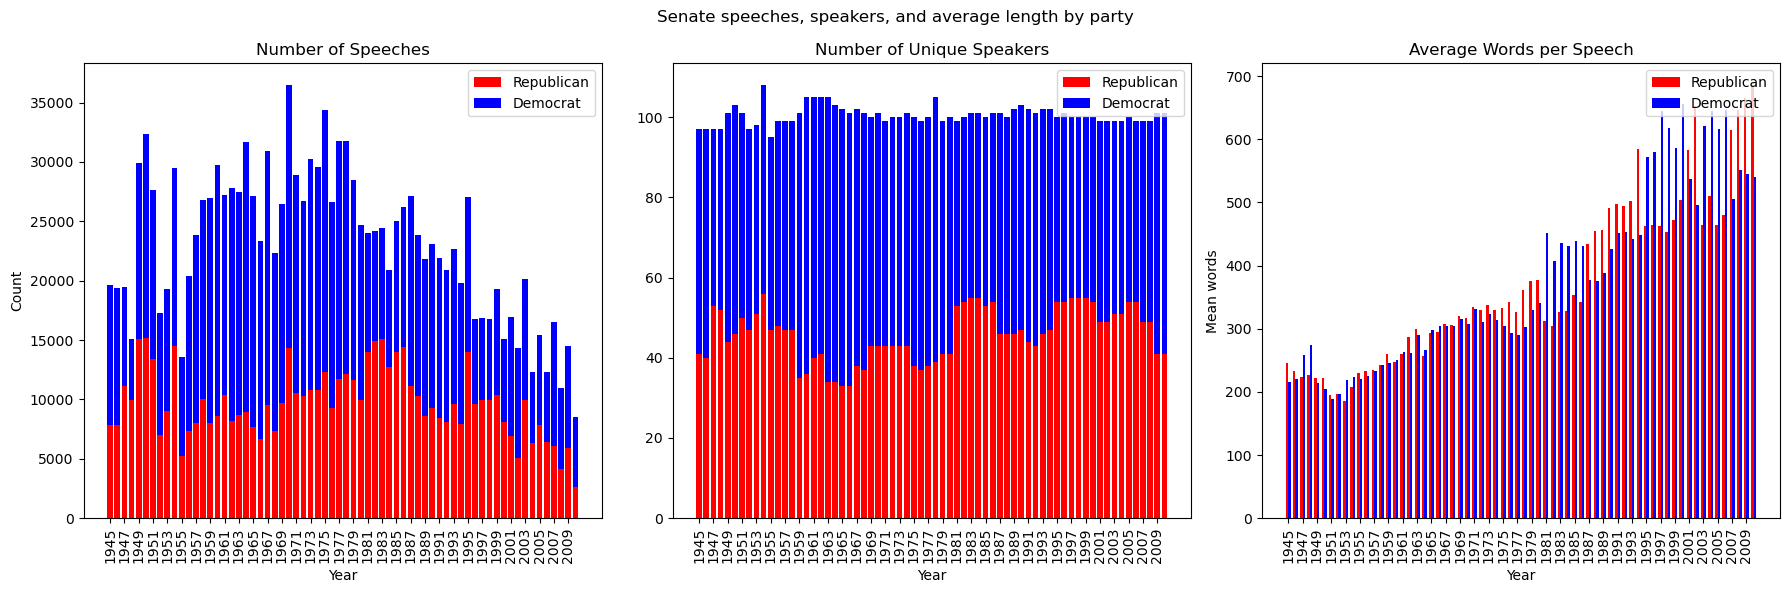

In [10]:
# ---------- collect the tables built in Cell 1 ----------
all_stats = pd.concat(senate_result_frames, ignore_index=True)


agg = (
    all_stats
    .groupby(['year', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
        num_speakers=('num_speakers', 'sum'),
        mean_words  =('mean_words',  'mean'))
)

# wide tables
speech_pct   = all_stats.pivot(index='year', columns='party', values='pct_speeches').fillna(0)
speaker_pct  = all_stats.pivot(index='year', columns='party', values='pct_speakers').fillna(0)
speech_vals  = agg.pivot(index='year', columns='party', values='num_speeches').fillna(0)
speaker_vals = agg.pivot(index='year', columns='party', values='num_speakers').fillna(0)
mean_words   = agg.pivot(index='year', columns='party', values='mean_words').fillna(0)


# make sure both parties are present
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

years = speech_vals.index.astype(str)
x     = np.arange(len(years))          # numeric x‑positions

# assume speech_vals, speaker_vals, mean_words are already built
years = speech_vals.index.astype(str)
x     = np.arange(len(years))

rs, ds = speech_vals['Republican'],  speech_vals['Democrat']
ru, du = speaker_vals['Republican'], speaker_vals['Democrat']
rw, dw = mean_words['Republican'],   mean_words['Democrat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# A ‒ speeches
axes[0].bar(x, rs, color='red',  label='Republican')
axes[0].bar(x, ds, bottom=rs, color='blue', label='Democrat')
axes[0].set_title('Number of Speeches')
axes[0].set_ylabel('Count')

# B ‒ speakers
axes[1].bar(x, ru, color='red',  label='Republican')
axes[1].bar(x, du, bottom=ru, color='blue', label='Democrat')
axes[1].set_title('Number of Unique Speakers')

# C ‒ mean words (side‑by‑side)
bar_w = 0.35
axes[2].bar(x - bar_w/2, rw, width=bar_w, color='red',  label='Republican')
axes[2].bar(x + bar_w/2, dw, width=bar_w, color='blue', label='Democrat')
axes[2].set_title('Average Words per Speech')
axes[2].set_ylabel('Mean words')

# -------------- show only every 2nd year -----------------------------
tick_pos   = x[::2]      # 0, 2, 4, …
tick_labels = years[::2]

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Year')
    ax.legend(loc='upper right')

fig.suptitle('Senate speeches, speakers, and average length by party')
plt.tight_layout()
plt.show()


2

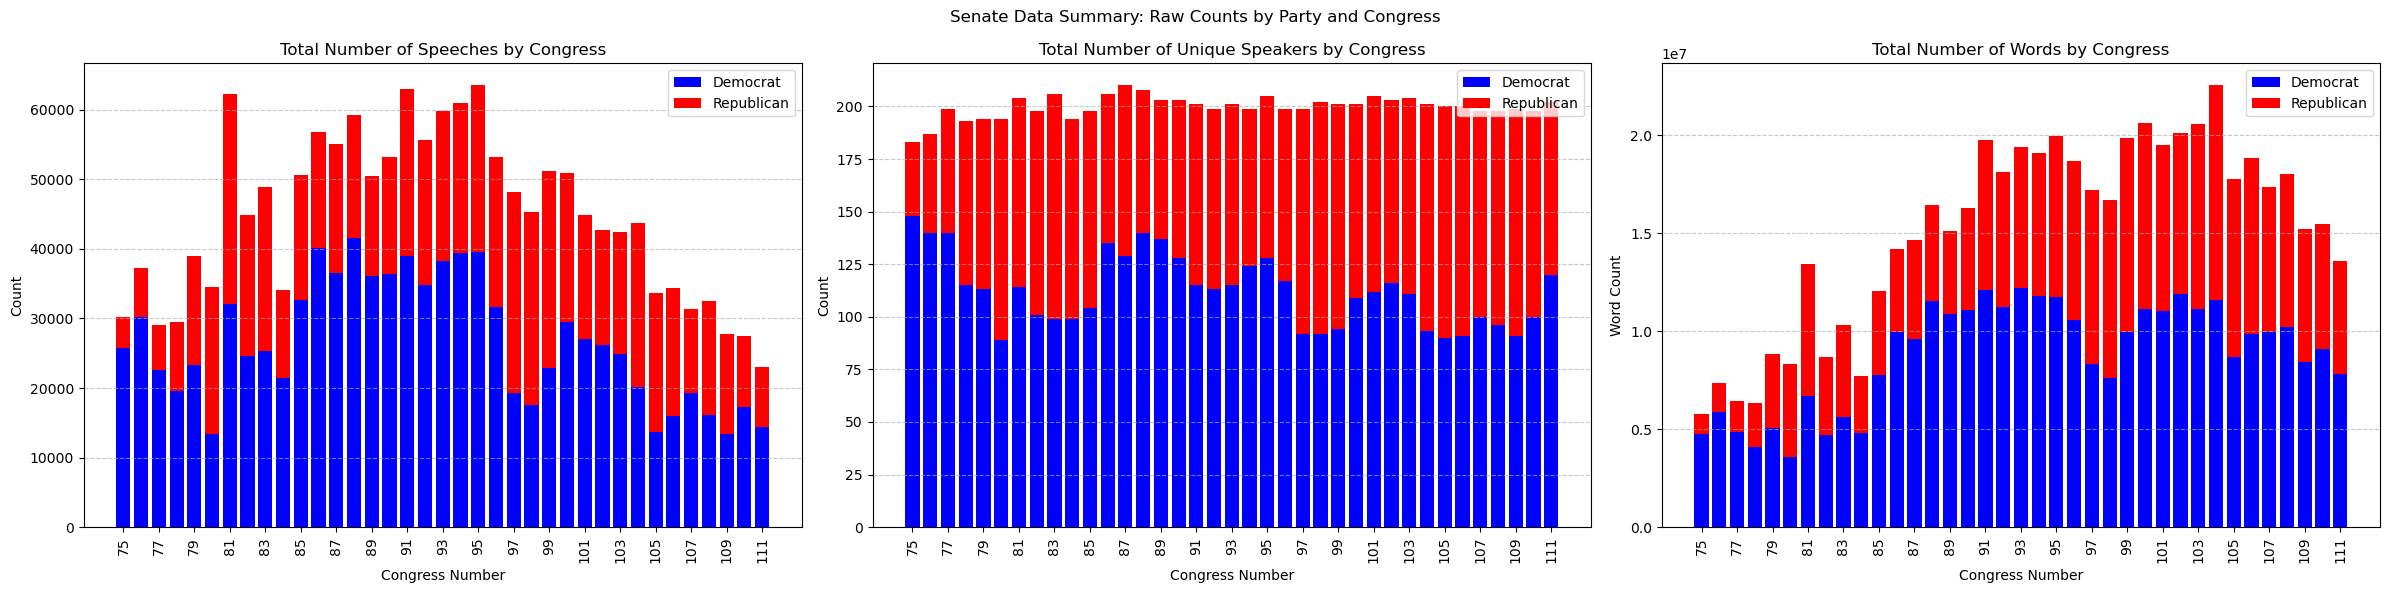

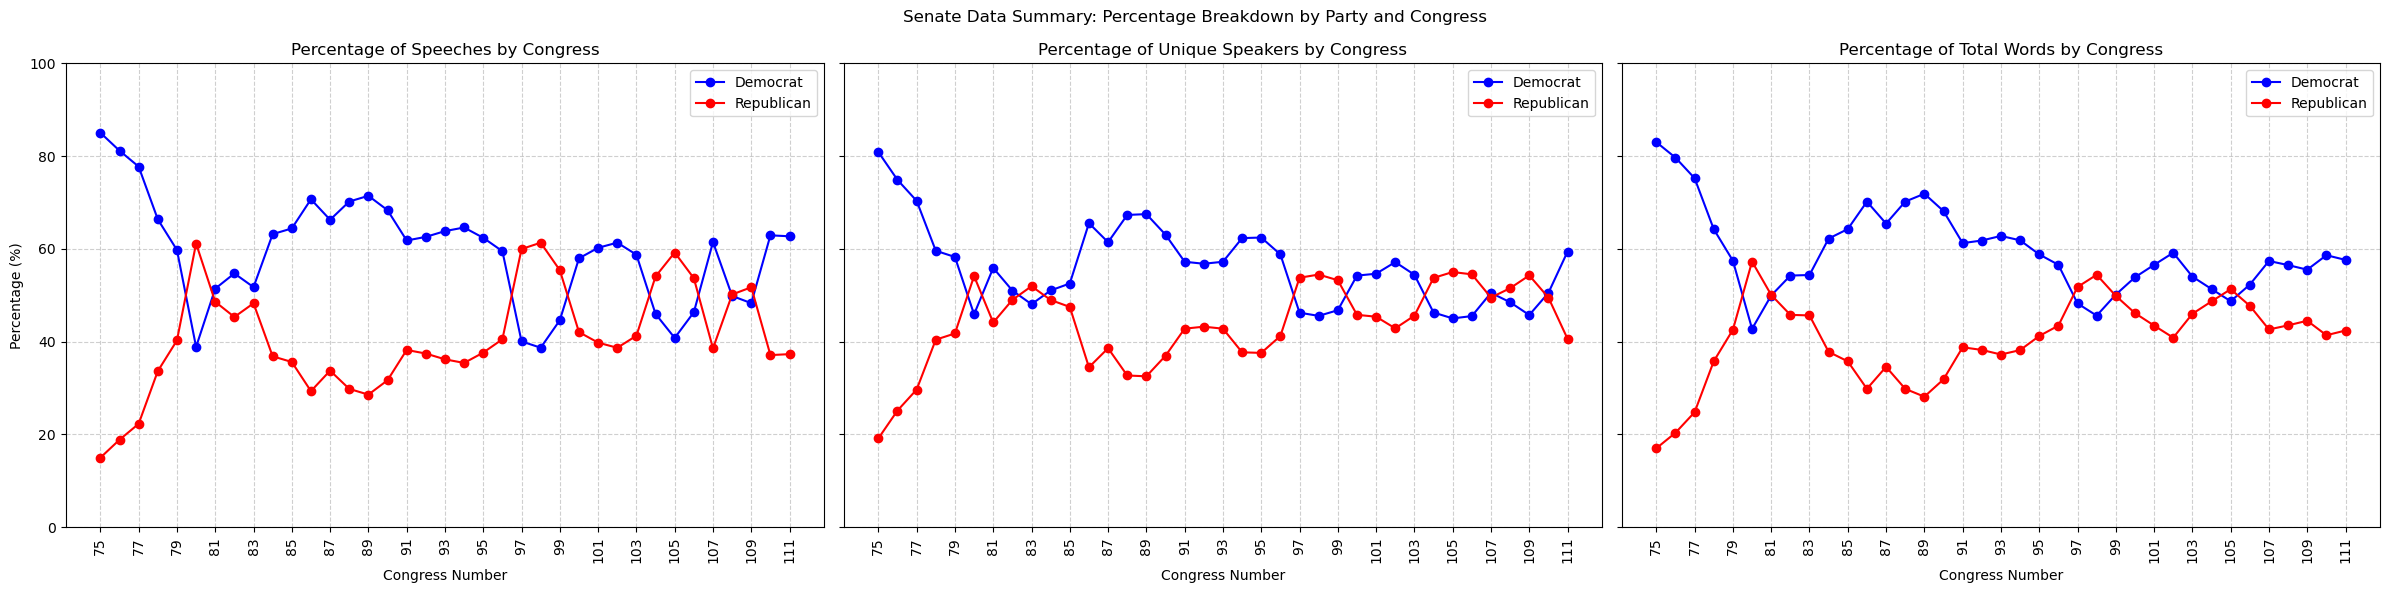

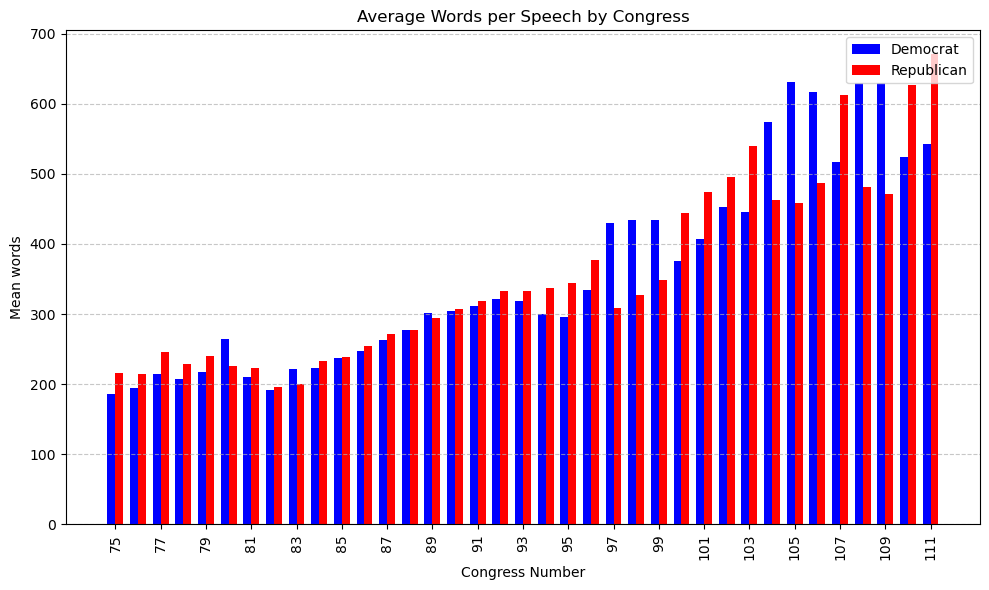

In [39]:


# Aggregate by 'Congress number' and 'party' first
# This ensures unique combinations of 'Congress number' and 'party'
agg = (
    all_stats_senate
    .groupby(['Congress number', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
         num_speakers=('num_speakers', 'sum'),
         # For mean_words, taking the mean of the yearly means might not be perfectly accurate
         # if the number of speeches varies greatly by year within a congress.
         # A more accurate approach would be to calculate total words per party per congress
         # and then divide by total speeches per party per congress.
         # Let's calculate total words first and then derive mean words per congress.
         total_words_sum=('num_speeches', lambda x: (x * all_stats_senate.loc[x.index, 'mean_words']).sum())
         # The lambda function above calculates the sum of (speeches * mean_words) for each group
    )
)

# Now calculate the mean_words at the Congress level from the aggregated total_words_sum
agg['mean_words'] = agg['total_words_sum'] / agg['num_speeches']

# Drop the intermediate total_words_sum column
agg = agg.drop(columns=['total_words_sum'])


# Create wide tables using the aggregated 'agg' DataFrame
speech_vals    = agg.pivot(index='Congress number', columns='party', values='num_speeches').fillna(0)
speaker_vals   = agg.pivot(index='Congress number', columns='party', values='num_speakers').fillna(0)
mean_words     = agg.pivot(index='Congress number', columns='party', values='mean_words').fillna(0)

# Calculate total words at the Congress level from the aggregated data
total_words_vals = (speech_vals * mean_words).fillna(0)


# Calculate percentages based on the Congress-level totals
congress_total_speeches = speech_vals.sum(axis=1)
congress_total_speakers = speaker_vals.sum(axis=1)
congress_total_words    = total_words_vals.sum(axis=1)

# Avoid division by zero
congress_total_speeches = congress_total_speeches.replace(0, np.nan)
congress_total_speakers = congress_total_speakers.replace(0, np.nan)
congress_total_words    = congress_total_words.replace(0, np.nan)


speech_pct = speech_vals.divide(congress_total_speeches, axis=0) * 100
speaker_pct = speaker_vals.divide(congress_total_speakers, axis=0) * 100
total_words_pct = total_words_vals.divide(congress_total_words, axis=0) * 100

# Fill NaNs created by division by zero
speech_pct = speech_pct.fillna(0)
speaker_pct = speaker_pct.fillna(0)
total_words_pct = total_words_pct.fillna(0)


# Ensure both parties are present in all tables after pivoting and calculations
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, total_words_vals, total_words_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

# Use 'Congress number' for x-axis labels and positions
congress_numbers = speech_vals.index.astype(str)
x                = np.arange(len(congress_numbers)) # numeric x‑positions

# Sort columns to ensure consistent order for stacking (e.g., Democrat then Republican)
party_order = ['Democrat', 'Republican']
speech_vals = speech_vals[party_order]
speaker_vals = speaker_vals[party_order]
total_words_vals = total_words_vals[party_order]
speech_pct = speech_pct[party_order]
speaker_pct = speaker_pct[party_order]
total_words_pct = total_words_pct[party_order]
mean_words = mean_words[party_order]


# --- Plotting Raw Counts (3 plots) ---
fig_raw, axes_raw = plt.subplots(1, 3, figsize=(24, 6), sharex=True) # Shared x-axis

# Plot Raw Speeches (Stacked Bar)
axes_raw[0].bar(x, speech_vals['Democrat'], color='blue', label='Democrat')
axes_raw[0].bar(x, speech_vals['Republican'], bottom=speech_vals['Democrat'], color='red', label='Republican')
axes_raw[0].set_title('Total Number of Speeches by Congress')
axes_raw[0].set_ylabel('Count')
axes_raw[0].legend(loc='upper right')
axes_raw[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Raw Unique Speakers (Stacked Bar)
axes_raw[1].bar(x, speaker_vals['Democrat'], color='blue', label='Democrat')
axes_raw[1].bar(x, speaker_vals['Republican'], bottom=speaker_vals['Democrat'], color='red', label='Republican')
axes_raw[1].set_title('Total Number of Unique Speakers by Congress')
axes_raw[1].set_ylabel('Count')
axes_raw[1].legend(loc='upper right')
axes_raw[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Raw Total Words (Stacked Bar)
axes_raw[2].bar(x, total_words_vals['Democrat'], color='blue', label='Democrat')
axes_raw[2].bar(x, total_words_vals['Republican'], bottom=total_words_vals['Democrat'], color='red', label='Republican')
axes_raw[2].set_title('Total Number of Words by Congress')
axes_raw[2].set_ylabel('Word Count')
axes_raw[2].legend(loc='upper right')
axes_raw[2].grid(axis='y', linestyle='--', alpha=0.7)

# Configure X-axis for Raw Counts figure
tick_pos = x[::2] # Show every 2nd Congress number
tick_labels = congress_numbers[::2]
for ax in axes_raw:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90) # Rotate labels for readability
    ax.set_xlabel('Congress Number')

fig_raw.suptitle('Senate Data Summary: Raw Counts by Party and Congress')
plt.tight_layout()
plt.show()


# --- Plotting Percentages (3 plots) ---
fig_pct, axes_pct = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True) # Shared x and y-axis (0-100%)

# Plot Percentage of Speeches (Line plot)
axes_pct[0].plot(x, speech_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[0].plot(x, speech_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[0].set_title('Percentage of Speeches by Congress')
axes_pct[0].set_ylabel('Percentage (%)')
axes_pct[0].set_ylim(0, 100) # Set y-axis limits from 0 to 100
axes_pct[0].legend(loc='upper right')
axes_pct[0].grid(True, linestyle='--', alpha=0.6)

# Plot Percentage of Unique Speakers (Line plot)
axes_pct[1].plot(x, speaker_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[1].plot(x, speaker_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[1].set_title('Percentage of Unique Speakers by Congress')
# axes_pct[1].set_ylabel('Percentage (%)') # sharey=True
axes_pct[1].set_ylim(0, 100)
axes_pct[1].legend(loc='upper right')
axes_pct[1].grid(True, linestyle='--', alpha=0.6)

# Plot Percentage of Total Words (Line plot)
axes_pct[2].plot(x, total_words_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[2].plot(x, total_words_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[2].set_title('Percentage of Total Words by Congress')
# axes_pct[2].set_ylabel('Percentage (%)') # sharey=True
axes_pct[2].set_ylim(0, 100)
axes_pct[2].legend(loc='upper right')
axes_pct[2].grid(True, linestyle='--', alpha=0.6)

# Configure X-axis for Percentage plots figure
for ax in axes_pct:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Congress Number')
    # Grid already added

fig_pct.suptitle('Senate Data Summary: Percentage Breakdown by Party and Congress')
plt.tight_layout()
plt.show()


# --- Plotting Average Words per Speech (Separate plot as it's a mean) ---
# Use a side-by-side bar plot for this
fig_avg_words, ax_avg_words = plt.subplots(figsize=(10, 6))
bar_w = 0.35
ax_avg_words.bar(x - bar_w/2, mean_words['Democrat'], width=bar_w, color='blue', label='Democrat')
ax_avg_words.bar(x + bar_w/2, mean_words['Republican'], width=bar_w, color='red', label='Republican')
ax_avg_words.set_title('Average Words per Speech by Congress')
ax_avg_words.set_ylabel('Mean words')
ax_avg_words.set_xticks(tick_pos)
ax_avg_words.set_xticklabels(tick_labels, rotation=90)
ax_avg_words.set_xlabel('Congress Number')
ax_avg_words.legend(loc='upper right')
ax_avg_words.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## token

In [ ]:
# Define the fixed word count threshold
LENGTH_THRESHOLD = 350

# Initialize a list to store stats for speeches over the threshold
house_speeches_over_threshold_stats = []

for i in range(79, 112):

    "------ Loading files -------"

    print(f'── Processing Congress {i} (Threshold >= {LENGTH_THRESHOLD} words) ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"

    # Check if file exists before trying to read
    if not house_file.exists():
        print(f"Warning: File not found for Congress {i}: {house_file}")
        continue # Skip this iteration if file is missing

    try:
        df = pd.read_csv(house_file)
    except Exception as e:
        print(f"Error reading file for Congress {i}: {e}")
        continue # Skip this iteration on error


    "------ Filtering and Calculating Stats for Speeches over Threshold -------"

    word_counts = df["word_count"]

    # Filter the DataFrame to get only speeches with word_count >= LENGTH_THRESHOLD
    speeches_over_threshold_df = df[word_counts >= LENGTH_THRESHOLD].copy() # .copy() to avoid SettingWithCopyWarning

    # Check if there are any speeches that meet the threshold in this Congress
    if not speeches_over_threshold_df.empty:
        # Calculate descriptive statistics for this subset of speeches
        stats_over_threshold = speeches_over_threshold_df["word_count"].describe().to_frame().T

        # Add the Congress number
        stats_over_threshold["Congress number"] = i

        # Reorder columns to put 'Congress number' first
        cols_over_threshold = stats_over_threshold.columns.tolist()
        new_order_over_threshold = ['Congress number'] + [col for col in cols_over_threshold if col != 'Congress number']
        stats_over_threshold = stats_over_threshold[new_order_over_threshold]

        # Append to the list
        house_speeches_over_threshold_stats.append(stats_over_threshold)
    else:
        # Handle cases where no speeches meet the threshold for a given Congress
        print(f"No speeches found >= {LENGTH_THRESHOLD} words for Congress {i}")
        # You might want to append a row of zeros/NaNs here if you need a complete table
        # For now, we'll just skip appending for this Congress


    # --- Your original loop code for overall stats or party stats can remain here if needed ---
    # "------ Grouping  -------"
    # ... (your grouping code) ...
    # house_result_frames.append(house_party_year_stats.reset_index())
    # ----------------------------------------------------------------------------------------


# After the loop, concatenate the list of stats DataFrames for speeches over the threshold
if house_speeches_over_threshold_stats:
    house_speeches_over_threshold_df = pd.concat(house_speeches_over_threshold_stats, ignore_index=True)

    # Optional: Round columns for cleaner display
    house_speeches_over_threshold_df_rounded = house_speeches_over_threshold_df.round({
        'count': 0,      # Count should be integer
        'mean': 2,
        'std': 2,
        'min': 0,
        '25%': 0,
        '50%': 0,
        '75%': 0,
        'max': 0
    })


    # Display the resulting DataFrame
    print(f"\n--- Speech Length Stats (Speeches >= {LENGTH_THRESHOLD} words) ---")
    print(house_speeches_over_threshold_df_rounded)
else:
    print(f"\nNo speeches found >= {LENGTH_THRESHOLD} words across the specified Congresses.")

In [ ]:
print(senate_speech_length_df.head())